# Random Forests

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/logo.png" width=150>

In this lesson, we will explore decision trees and expand on them to build random forests. This type of model, unlike the linear and logistic regression models we've seen so far, have no weights to learn but they offer great interpretability. 





# Overview

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/dtree.jpg" width=350>

* **Objective:**  Given some data, choose features and determine conditions to split the data which result in determining the predictions.
* **Advantages:**
  * Decision tree's can be for classification or regression trees.
  * Highly interpretable as you can follow the exact line of though the model used.
  * Very little data preparation needed.
* **Disadvantages:**
  * Poor performance when training data is smaller than number of classes.
* **Miscellaneous:** A group of decision trees created a random forest, where the prediction accouts for decisions from all the trees together.

# Training

Let's look at our example decision tree up top which is used to decide whether it's alright to play outside. The data has three features (weather, humiditiy and wind) and the outcome (yes or no).

*Steps*: 
1.   Split the data based on each feature. (ex. Determine yes or no from just the outlook, humidity or wind feature.
2.   Calculate the cost for splitting by each feature. Popular algorithms include CART which uses the Gini index or ID3 which uses entropy and information gain to decide on the best split. They all essentially measure the impurity/disorder in the collection of predictions. Check this [blog post](https://medium.com/deep-math-machine-learning-ai/chapter-4-decision-trees-algorithms-b93975f7a1f1) for a detailed breakdown of information gain calculations. 

  * $ H(X) = \sum_{c \in C} -p(c) log_2p(c)$
  * where:
      * H(X): entropy of entire dataset X
      * C: set of classes
      * p(c): proportion of # of instances in class c to all instances
  
  For a binary classification problem, entropy is 0 when all the examples in a split are the same and 1 when half belong to one class (worst case scenario). Once we determine entropy, we need to determine the information gain (IG) that we achieved (ie. how much uncertainty was reduced after we split the data X on the feature F).
  
  * $ IG(F, X) = H(S) - \sum_{t\in T}p(t)H(t) $
  * where:
      * IG(F. X): information gained by splitting X by feature F
      * H(X): entropy of entire dataset X
      * T: subsets created by splitting on feature F
      * p(t): proportion of # of instances in t to all instances
      * H(t): entropy of subset t
      
 **Note**: for regrssion, you can use standard deviation of a group instead of IG.

3.   The split with the highest IG is the first feature to split by (which is the root of your tree).
4.    Repeat this for all the other features to create branches to our initial feature split. At the end, we will have leaves which will hold mostly samples from the same class.

  

# Data

We're going to the load the titanic dataset we looked at in lesson 03_Pandas.

In [0]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib

In [0]:
# Arguments
args = Namespace(
    seed=1234,
    data_file="titanic.csv",
    train_size=0.75,
    test_size=0.25,
    num_epochs=100,
    max_depth=4,
    min_samples_leaf=5,
    n_estimators=10, # of trees in the forest
)

# Set seed for reproducability
np.random.seed(args.seed)

In [0]:
# Upload data from GitHub to notebook's local drive
url = "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/titanic.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file, 'wb') as f:
    f.write(html)

In [0]:
# Read from CSV to Pandas DataFrame
df = pd.read_csv(args.data_file, header=0)
df.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,1
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,1
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,0
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,0
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,0


# Scikit-learn implementation

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
# Preprocessing
def preprocess(df):
  
    # Drop rows with NaN values
    df = df.dropna()

    # Drop text based features (we'll learn how to use them in later lessons)
    features_to_drop = ["name", "cabin", "ticket"]
    df = df.drop(features_to_drop, axis=1)

    # pclass, sex, and embarked are categorical features
    # We need to convert strings to floats for decision trees instead of
    # using dummy variables.
    df['sex'] = df['sex'].map( {'female': 0, 'male': 1} ).astype(int)
    df["embarked"] = df['embarked'].dropna().map( {'S':0, 'C':1, 'Q':2} ).astype(int)

    return df

In [0]:
# Preprocess the dataset
df = preprocess(df)
df.head()

,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,1,0,29.0000,0,0,211.3375,0,1
1,1,1,0.9167,1,2,151.5500,0,1
2,1,0,2.0000,1,2,151.5500,0,0
3,1,1,30.0000,1,2,151.5500,0,0
4,1,0,25.0000,1,2,151.5500,0,0


In [0]:
# Split the data
mask = np.random.rand(len(df)) < args.train_size
train_df = df[mask]
test_df = df[~mask]
print ("Train size: {0}, test size: {1}".format(len(train_df), len(test_df)))

Train size: 199, test size: 71


In [0]:
# Separate X and y
X_train = train_df.drop(["survived"], axis=1)
y_train = train_df["survived"]
X_test = test_df.drop(["survived"], axis=1)
y_test = test_df["survived"]

**Note**: Play around with the max_depth and min_samples values below to see the change in performance and decision tree.
How do we know when to stop splitting? In cases where we have a large number of features, our decision tree will be very large. If we keep splitting, we could have overfitting. There are a few techniques to tackle this:

*  Set a minimum # of training samples on each leaf.
*  Set a maximum depth (length of longest path from root to leaf).
*  Prune the tree by removing features that add little to no information gain.

In [0]:
# Initialize the model
dtree = DecisionTreeClassifier(criterion="entropy", random_state=args.seed, 
                               max_depth=args.max_depth, 
                               min_samples_leaf=args.min_samples_leaf)

In [0]:
# Training
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

In [0]:
# Predictions
pred_train = dtree.predict(X_train)
pred_test = dtree.predict(X_test)

# Evaluation

In [0]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [0]:
# Accuracy
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print ("train acc: {0:.2f}, test acc: {1:.2f}".format(train_acc, test_acc))

train acc: 0.82, test acc: 0.70


In [0]:
# Calculate other evaluation metrics 
precision, recall, F1, _ = precision_recall_fscore_support(y_test, pred_test, average="binary")
print ("precision: {0:.2f}. recall: {1:.2f}, F1: {2:.2f}".format(precision, recall, F1))

precision: 0.70. recall: 0.79, F1: 0.75


# Interpretability

In [0]:
# Install necessary packages
!apt-get install graphviz
!pip install pydotplus

In [0]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

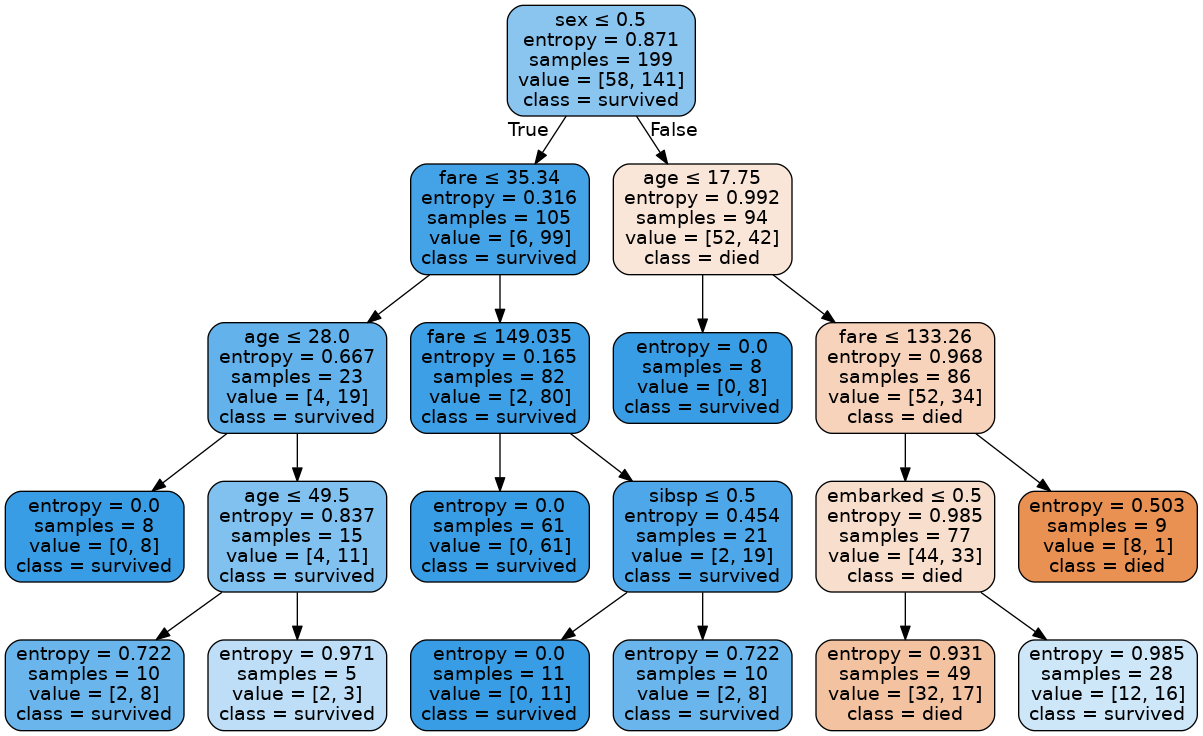

In [0]:
# Interpretability
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data, 
                feature_names=list(train_df.drop(['survived'], axis=1)), 
                class_names = ['died', 'survived'],
                rounded = True, filled= True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png(), width=500, height=300)

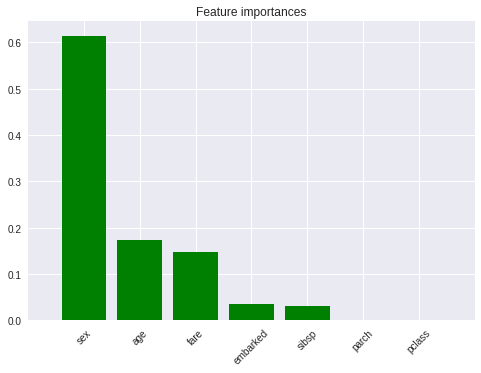

sex - 0.615
age - 0.174
fare - 0.147
embarked - 0.035
sibsp - 0.030
parch - 0.000
pclass - 0.000


In [0]:
# Feature importances
features = list(X_test.columns)
importances = dtree.feature_importances_
indices = np.argsort(importances)[::-1]
num_features = len(importances)

# Plot the feature importances of the tree
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], color="g", align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, num_features])
plt.show()

# Print values
for i in indices:
    print ("{0} - {1:.3f}".format(features[i], importances[i]))

# Random forests

A group, or ensemble, of decision trees together create a random forest. The idea is that a group of different trees will yield more accurate predictions compared to a single decision tree. But how can we have different trees if they're all made using the same data and optimized on a metric like IG? The trick here is that the different decision trees in the random forest are made of different subsets of data and even different thresholds for features. 

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/forest.png" width=600>

# Scikit-learn implementation

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
# Initialize Random forest
forest = RandomForestClassifier(
    n_estimators=args.n_estimators, criterion="entropy", 
    max_depth=args.max_depth, min_samples_leaf=args.min_samples_leaf)

In [0]:
# Train
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
# Predictions
pred_train = forest.predict(X_train)
pred_test = forest.predict(X_test)

In [0]:
# Accuracy
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print ("train acc: {0:.2f}, test acc: {1:.2f}".format(train_acc, test_acc))

# Calculate other evaluation metrics 
precision, recall, F1, _ = precision_recall_fscore_support(y_test, pred_test, average="binary")
print ("precision: {0:.2f}. recall: {1:.2f}, F1: {2:.2f}".format(precision, recall, F1))

train acc: 0.80, test acc: 0.68
precision: 0.65. recall: 0.87, F1: 0.75


# Interpretability

It's very easy to inspect random forests and derive feature importance values. 

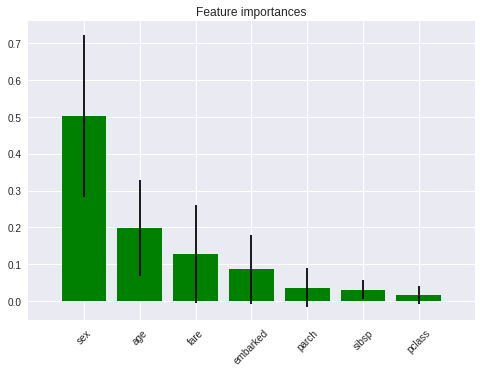

sex - 0.503
age - 0.198
fare - 0.129
embarked - 0.086
parch - 0.037
sibsp - 0.031
pclass - 0.017


In [0]:
# Feature importances
features = list(X_test.columns)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
num_features = len(importances)

# Plot the feature importances of the tree
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], yerr=std[indices], 
        color="g", align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, num_features])
plt.show()

# Print values
for i in indices:
    print ("{0} - {1:.3f}".format(features[i], importances[i]))

# Grid Search

In our random forest, we have many different hyperparameters (criterion, max_depth, etc.) and many of the models we will see in future lessons will have even more parameters. How will we know what values to pick? We have to tune the values based on the performance they yield on the validation set. Scikit learn offers functions to do exhaustive grid search so that we can tune our hyperparameters. 

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
# Create the parameter grid 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 50],
    'max_features': [len(features)],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [4, 8],
    'n_estimators': [5, 10, 50] # of trees
}

In [0]:
# Initialize random forest
forest = RandomForestClassifier()

In [0]:
# Instantiate grid search
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=3, 
                           n_jobs=-1, verbose=1)

In [0]:
# Fit grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    3.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [10, 20, 50], 'max_features': [7], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [4, 8], 'n_estimators': [5, 10, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [0]:
# See the best combination of parameters
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 10}

In [0]:
# Train using best parameters
best_forest = grid_search.best_estimator_
best_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
# Predictions
pred_train = best_forest.predict(X_train)
pred_test = best_forest.predict(X_test)

In [0]:
# Accuracy
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print ("train acc: {0:.2f}, test acc: {1:.2f}".format(train_acc, test_acc))

# Calculate other evaluation metrics 
precision, recall, F1, _ = precision_recall_fscore_support(y_test, pred_test, average="binary")
print ("precision: {0:.2f}. recall: {1:.2f}, F1: {2:.2f}".format(precision, recall, F1))

train acc: 0.89, test acc: 0.70
precision: 0.70. recall: 0.79, F1: 0.75


# TODO

- regression example
- gini vs. entropy